In [1]:
! pip install arch

In [2]:
# Leer Archivos Drive
from google.colab import drive
import pandas as pd

# Mount Google Drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# =====================
# Librerías estándar
# =====================
import sys
import warnings
from typing import Union, Optional
from datetime import datetime

# =====================
# Ciencia de datos
# =====================
import pandas as pd
import numpy as np

# =====================
# Visualización
# =====================
import matplotlib.pyplot as plt
import seaborn as sns

# =====================
# Series de tiempo y estadística
# =====================
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy import stats
from scipy.stats import norm

# Phillips-Perron (con verificación de disponibilidad)
try:
    from arch.unitroot import PhillipsPerron
    HAVE_PP = True
except Exception:
    HAVE_PP = False

# =====================
# Configuración
# =====================
warnings.filterwarnings("ignore")

# =====================
# Importar funciones auxiliares desde Google Drive
# =====================
sys.path.append('/content/drive/MyDrive/Datos_EESS')
print(f"sys.path after adding: {sys.path}")  # Verificación
from funciones_auxiliares import *



sys.path after adding: ['/content', '/env/python', '/usr/lib/python312.zip', '/usr/lib/python3.12', '/usr/lib/python3.12/lib-dynload', '', '/usr/local/lib/python3.12/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.12/dist-packages/IPython/extensions', '/root/.ipython', '/content/drive/MyDrive/Datos_EESS']


In [4]:

# Leer csv
try:
    df = pd.read_csv('/content/drive/MyDrive/Datos_EESS/merged_df_clean.csv')
    print("CSV file loaded successfully!")
    #display(df.head()) # Display the first 5 rows
except FileNotFoundError:
    print("Error: Make sure the file path is correct.")
except Exception as e:
    print(f"An error occurred: {e}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
CSV file loaded successfully!


### ANALISIS DE SERIES

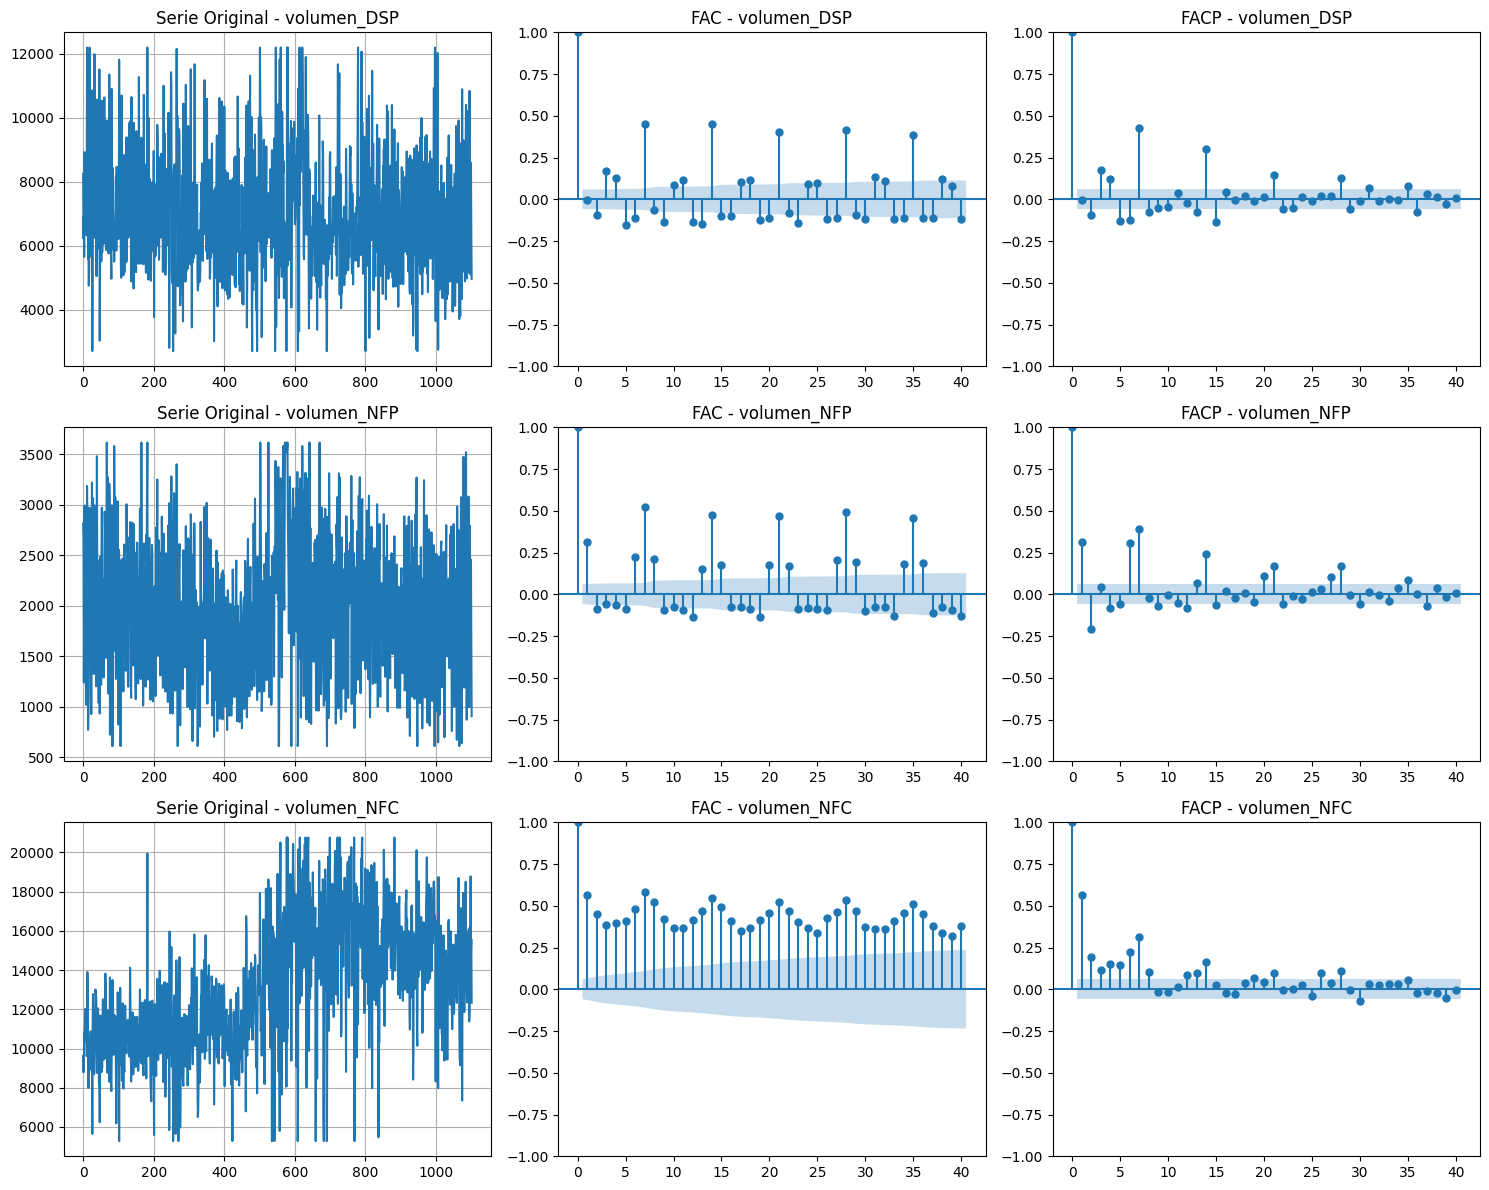

In [5]:
### SERIE ORIGINAL
# Seleccionar las tres series
series_dict = {
    "volumen_DSP": df["volumen_DSP"].dropna(),
    "volumen_NFP": df["volumen_NFP"].dropna(),
    "volumen_NFC": df["volumen_NFC"].dropna(),
}

# Graficar la serie original, FAC y FACP
fig, axes = plt.subplots(len(series_dict), 3, figsize=(15, 12))

for i, (nombre, serie) in enumerate(series_dict.items()):
    # Serie original
    axes[i, 0].plot(serie)
    axes[i, 0].set_title(f"Serie Original - {nombre}")
    axes[i, 0].grid(True)

    # FAC (ACF)
    plot_acf(serie, ax=axes[i, 1], lags=40)
    axes[i, 1].set_title(f"FAC - {nombre}")

    # FACP (PACF)
    plot_pacf(serie, ax=axes[i, 2], lags=40, method="ywm")
    axes[i, 2].set_title(f"FACP - {nombre}")

plt.tight_layout()
plt.show()

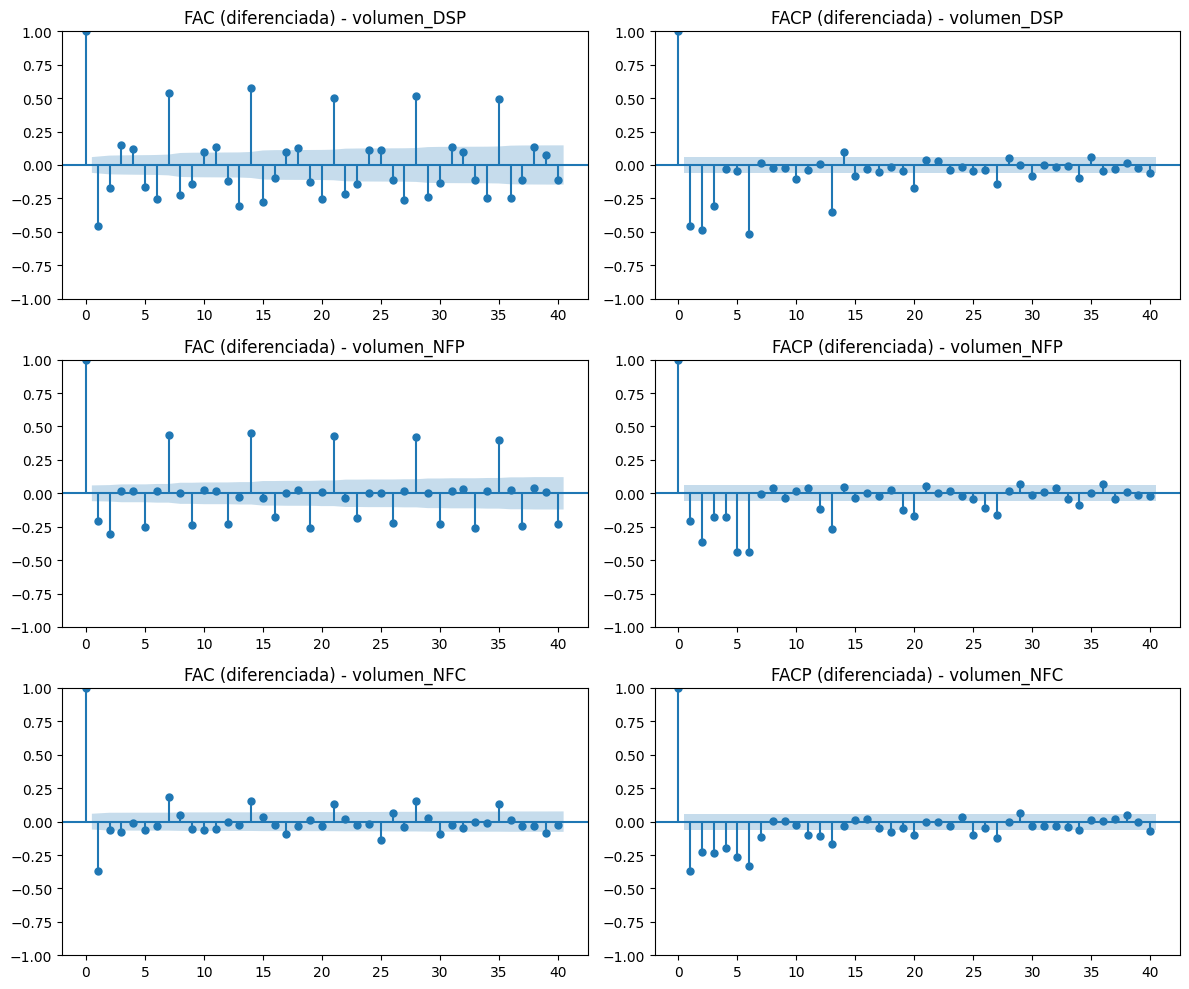

In [6]:
# Seleccionar las tres series
series_dict = {
    "volumen_DSP": df["volumen_DSP"].dropna(),
    "volumen_NFP": df["volumen_NFP"].dropna(),
    "volumen_NFC": df["volumen_NFC"].dropna(),
}

# Crear un DataFrame con las primeras diferencias
df_diff = pd.DataFrame({nombre: serie.diff().dropna() for nombre, serie in series_dict.items()})

# Graficar FAC y FACP de las series diferenciadas
fig, axes = plt.subplots(len(df_diff.columns), 2, figsize=(12, 10))

for i, nombre in enumerate(df_diff.columns):
    serie_diff = df_diff[nombre]

    # FAC (ACF)
    plot_acf(serie_diff, ax=axes[i, 0], lags=40)
    axes[i, 0].set_title(f"FAC (diferenciada) - {nombre}")

    # FACP (PACF)
    plot_pacf(serie_diff, ax=axes[i, 1], lags=40, method="ywm")
    axes[i, 1].set_title(f"FACP (diferenciada) - {nombre}")

plt.tight_layout()
plt.show()

In [7]:
# === Pruebas de raíces unitarias en tres series ===
series_names = ["volumen_DSP", "volumen_NFP", "volumen_NFC"]
series = {name: df[name].dropna() for name in series_names}

In [8]:
# Ejecutar pruebas y consolidar
rows = []
for name, x in series.items():
    adf_c  = run_adf(x, regression="c")
    adf_ct = run_adf(x, regression="ct")
    kpss_c  = run_kpss_test(x, regression="c")
    kpss_ct = run_kpss_test(x, regression="ct")
    pp_c = run_pp(x, trend="c")
    pp_ct = run_pp(x, trend="ct")

    rows.append({
        "serie": name,
        "ADF(c)_stat": adf_c["stat"], "ADF(c)_p": adf_c["pvalue"],
        "ADF(ct)_stat": adf_ct["stat"], "ADF(ct)_p": adf_ct["pvalue"],
        "KPSS(c)_stat": kpss_c["stat"], "KPSS(c)_p": kpss_c["pvalue"],
        "KPSS(ct)_stat": kpss_ct["stat"], "KPSS(ct)_p": kpss_ct["pvalue"],
        "PP(c)_p": None if not pp_c else pp_c["pvalue"],
        "PP(ct)_p": None if not pp_ct else pp_ct["pvalue"],
        "Interpretación": interpret_row(adf_c, adf_ct, kpss_c, kpss_ct, pp_c, pp_ct),
    })

resultados = pd.DataFrame(rows)
pd.set_option("display.max_colwidth", None)
print(resultados)

         serie  ADF(c)_stat  ADF(c)_p  ADF(ct)_stat  ADF(ct)_p  KPSS(c)_stat  \
0  volumen_DSP    -5.418074  0.000003     -5.555360   0.000018      0.379847   
1  volumen_NFP    -4.149662  0.000801     -4.163436   0.005081      0.466762   
2  volumen_NFC    -2.028727  0.274121     -2.923418   0.154764      4.463479   

   KPSS(c)_p  KPSS(ct)_stat  KPSS(ct)_p  PP(c)_p  PP(ct)_p  \
0   0.085842       0.095228        0.10      0.0       0.0   
1   0.049153       0.469960        0.01      0.0       0.0   
2   0.010000       0.818979        0.01      0.0       0.0   

                                                                                                                                                                                                                                                                                                                                         Interpretación  
0                                         ADF/PP con constante: sugiere estacionaria

DSP: Estacionaria

NFP: No estacionaria

NFC: No estacionaria

In [ ]:
df = df.sort_values("fecha").set_index("fecha")
df.index = pd.to_datetime(df.index, errors="coerce")
df = df[~df.index.isna()]

series_names = ["volumen_DSP", "volumen_NFP", "volumen_NFC"]
series = {n: df[n].astype(float).dropna() for n in series_names}

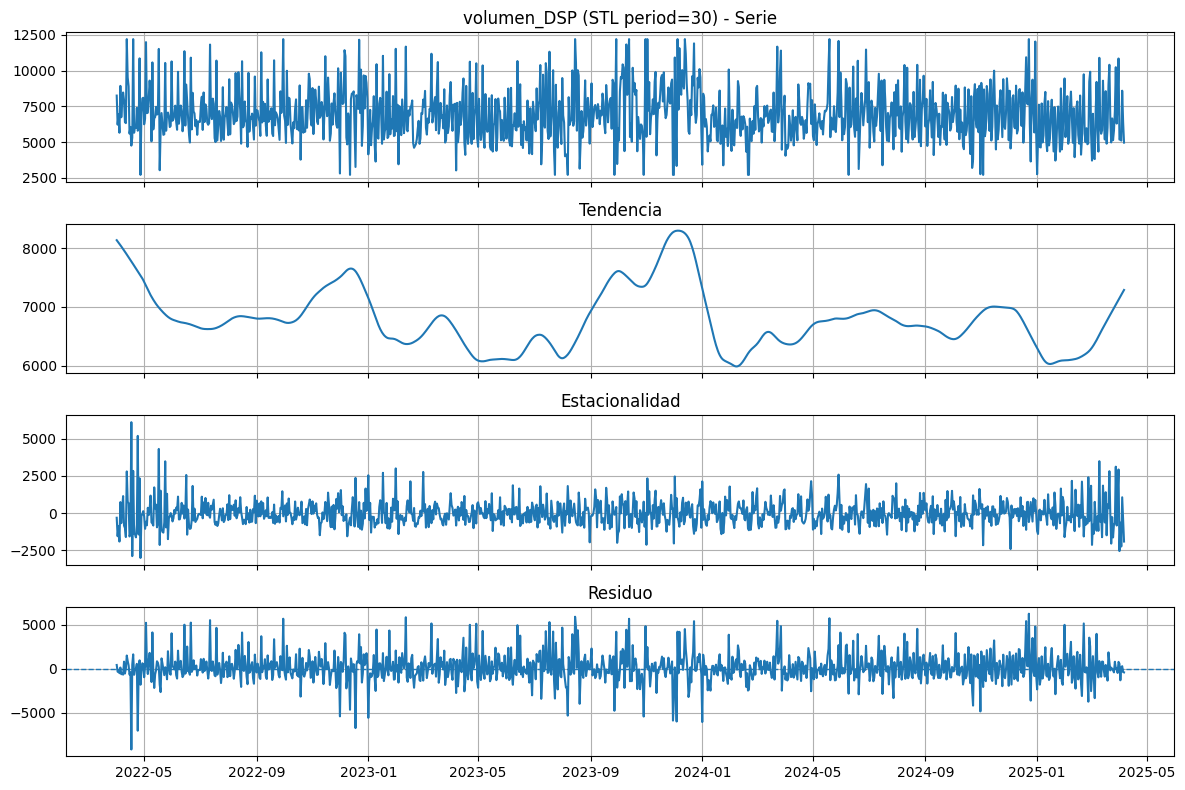

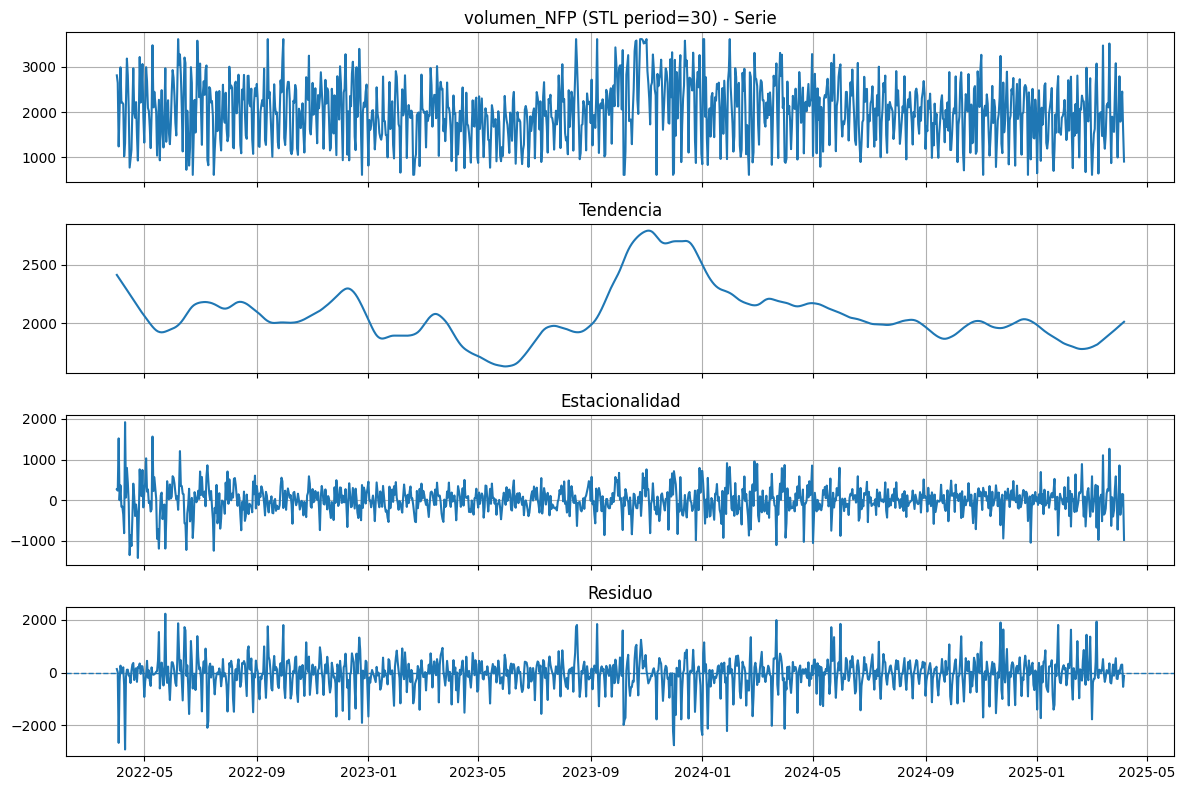

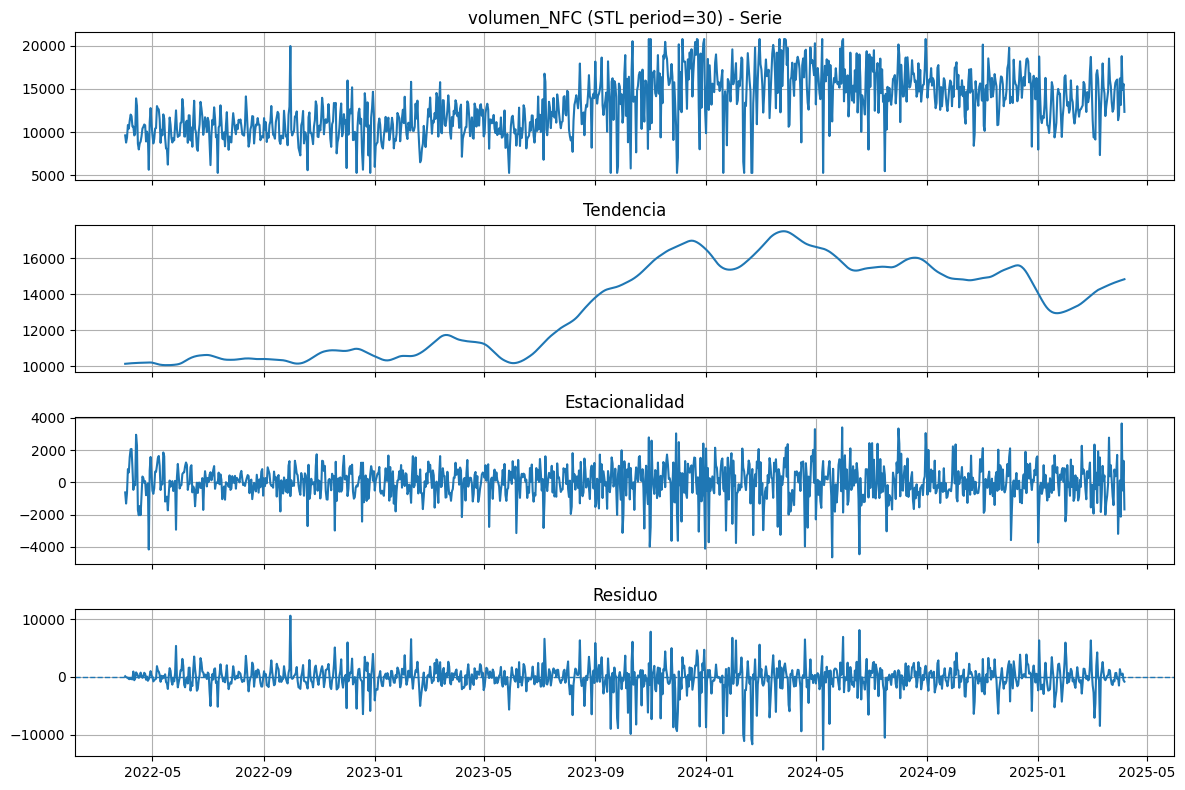


Resumen descomposición STL (varianza por componente)
         Serie  Período STL  %Var_Tendencia  %Var_Estacional  %Var_Residuo
0  volumen_DSP           30            7.55            22.11         82.31
1  volumen_NFP           30           13.20            27.24         87.60
2  volumen_NFC           30           55.17            10.55         48.79


In [12]:
# ---------- DESCOMPOSICION ----------

resumen = []
for name, s in series.items():
    res = stl_decompose(s,period=30)  # si querés forzar: stl_decompose(s, period=7)
    plot_stl(name, res)
    resumen.append({
        "Serie": name,
        "Período STL": res["period"],
        "%Var_Tendencia": round(res["pct_var"]["trend"], 2),
        "%Var_Estacional": round(res["pct_var"]["seasonal"], 2),
        "%Var_Residuo": round(res["pct_var"]["resid"], 2),
    })

tabla = pd.DataFrame(resumen)
print("\nResumen descomposición STL (varianza por componente)")
print(tabla)